# Reading FoF halo catalogs

[![Binder](https://mybinder.org/badge_logo.svg)](https://binder.flatironinstitute.org/v2/user/fvillaescusa/Quijote?filepath=/Tutorials/Reading_FoF.ipynb)

In [1]:
import numpy as np
import readgadget
import readfof
import redshift_space_library as RSL

In [2]:
snapdir = '/home/jovyan/Data/Halos/FoF/EQ_p/420' #folder hosting the catalogue
snapnum = 4                                      #number of the catalog (4-->z=0, 3-->z=0.5, 2-->z=1, 1-->z=2, 0-->z=3)

In Quijote, snapnum={4,3,2,1,0} corresponds to redshift {0, 0.5, 1, 2, 3}, but we recommend reading it directly
from the header of the corresponding snapshot. The header of the snapshot also contains information that is needed
for some particular operations such as move halos to redshift-space.

In [3]:
# get the name of the corresponding snapshot
snapshot = '/home/jovyan/Data/Snapshots/EQ_p/420/snapdir_%03d/snap_%03d'%(snapnum,snapnum)

# read the redshift, boxsize, cosmology...etc in the header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

print('BoxSize = %.3f Mpc/h'%BoxSize)
print('Number of particles in the snapshot:',Nall)
print('Omega_m = %.3f'%Omega_m)
print('Omega_l = %.3f'%Omega_l)
print('h = %.3f'%h)
print('redshift = %.1f'%redshift)

BoxSize = 1000.000 Mpc/h
Number of particles in the snapshot: [        0 134217728         0         0         0         0]
Omega_m = 0.318
Omega_l = 0.682
h = 0.671
redshift = 0.0


To read the halo catalog we do

In [4]:
# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False,
                          swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h  = FoF.GroupPos/1e3            #Halo positions in Mpc/h
vel_h  = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s
mass_h = FoF.GroupMass*1e10          #Halo masses in Msun/h
Np_h   = FoF.GroupLen                #Number of CDM particles in the halo. Even in simulations with massive neutrinos, this will be just the number of CDM particles

Lets print some information

In [5]:
print('%.3f < X_h  < %.3f Mpc/h'%(np.min(pos_h[:,0]), np.max(pos_h[:,0])))
print('%.3f < Y_h  < %.3f Mpc/h'%(np.min(pos_h[:,1]), np.max(pos_h[:,1])))
print('%.3f < Z_h  < %.3f Mpc/h'%(np.min(pos_h[:,2]), np.max(pos_h[:,2])))
print('%.3f < Vx_h < %.3f km/s'%(np.min(vel_h[:,0]), np.max(vel_h[:,0])))
print('%.3f < Vy_h < %.3f km/s'%(np.min(vel_h[:,1]), np.max(vel_h[:,1])))
print('%.3f < Vz_h < %.3f km/s'%(np.min(vel_h[:,2]), np.max(vel_h[:,2])))
print('%.3e < M_h < %.3e Msun/h'%(np.min(mass_h), np.max(mass_h)))
print('%d < Np < %d'%(np.min(Np_h), np.max(Np_h)))

0.003 < X_h  < 999.997 Mpc/h
0.004 < Y_h  < 999.997 Mpc/h
0.001 < Z_h  < 1000.000 Mpc/h
-1920.503 < Vx_h < 2176.723 km/s
-1891.656 < Vy_h < 2023.595 km/s
-1776.037 < Vz_h < 1855.787 km/s
1.313e+13 < M_h < 4.270e+15 Msun/h
20 < Np < 6504


By construction, we only keep halos that contain at least 20 dark matter particles. We can verify that the minimum mass of a halo corresponds to that

In [6]:
Minimum_mass = 20*Masses[1] #This is 20 times the mass of a single DM particle
print('%.3e should be equal to\n%.3e'%(Minimum_mass, np.min(mass_h)))

1.313e+13 should be equal to
1.313e+13


To get the information about a particular halo, just select its index

In [7]:
index = 45 #the index of the halo
print('Halo position:',pos_h[index],'Mpc/h')
print('Halo velocity:',vel_h[index],'km/s')
print('Halo mass: %.3e Msun/h'%mass_h[index])
print('Number of particles in the halo: %d'%Np_h[index])

Halo position: [557.547   854.5584  387.07922] Mpc/h
Halo velocity: [ 231.89758 -459.18256  655.8717 ] km/s
Halo mass: 1.910e+15 Msun/h
Number of particles in the halo: 2909


In some cases, we may want to work with halos in redshift-space rather than real-space.
We can move halos to redshift-space along a given axis as follows

In [8]:
# move halos to redshift-space. After this call, pos_h will contain the
# positions of the halos in redshift-space
axis = 0 #axis along which to displace halos
RSL.pos_redshift_space(pos_h, vel_h, BoxSize, Hubble, redshift, axis)

Lets finally compute a simple summary statistics from the catalog: the halo mass function

In [9]:
min_mass = 2e13 #minimum mass in Msun/h
max_mass = 1e15 #maximum mass in Msun/h
bins     = 30   #number of bins in the HMF

# Correct the masses of the FoF halos
mass_h = mass_h*(1.0-Np_h**(-0.6))

bins_mass = np.logspace(np.log10(min_mass), np.log10(max_mass), bins+1)
mass_mean = 10**(0.5*(np.log10(bins_mass[1:])+np.log10(bins_mass[:-1])))
dM        = bins_mass[1:] - bins_mass[:-1]

# compute the halo mass function (number of halos per unit volume per unit mass)
HMF = np.histogram(mass_h, bins=bins_mass)[0]/(dM*BoxSize**3)

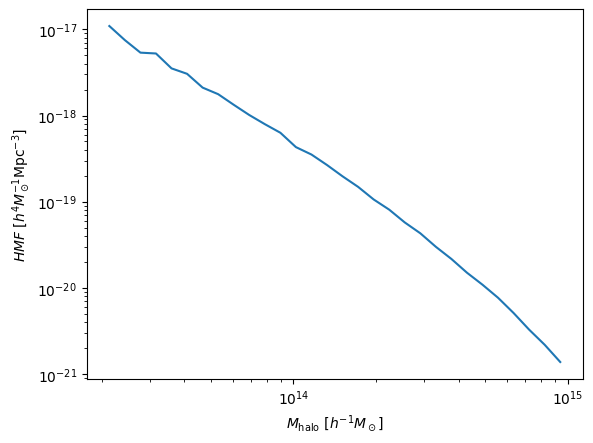

In [10]:
import matplotlib.pyplot as plt
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{\rm halo}~[h^{-1}M_\odot]$')
plt.ylabel(r'$HMF~[h^4M_\odot^{-1}{\rm Mpc}^{-3}]$')
plt.plot(mass_mean, HMF)
plt.show()